In [1]:
import json
import pandas as pd

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 999)

In [3]:
%%time
from pymongo import MongoClient

MONGO_HOST= 'mongodb://localhost/twitterdata'
client = MongoClient(MONGO_HOST)
db = client.twitterdata
coll = db.abortolegal

CPU times: user 15.3 ms, sys: 13.3 ms, total: 28.6 ms
Wall time: 38.8 ms


In [4]:
%%time
tweets = []
users = {}
cols_tweet = ['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text',
              'posicion', 'favorited', 'retweeted']
cols_user = [
             u'created_at',
             u'description',
             u'favourites_count',
             u'followers_count',
             u'friends_count',
             u'geo_enabled',
             u'id',
             u'lang',
             u'location',
             u'name',
             u'protected',
             u'screen_name',
             u'statuses_count',
             u'time_zone',
             u'verified']

for t in coll.find():
    tr = {c: t[c] for c in cols_tweet}
    tr['user_name'] = t['user']['name']
    tr['user_id'] = t['user']['id']
    tr['original_id'] = t['retweeted_status']['id'] if t['retweeted'] else t['id']
    tweets.append(tr)
    uid = t['user']['id'] 
    if uid not in users:
        users[uid] = {c: t['user'][c] for c in cols_user}

CPU times: user 4min 10s, sys: 5.44 s, total: 4min 16s
Wall time: 4min 17s


In [5]:
%%time
tweets = pd.DataFrame(tweets)
users = pd.DataFrame(users.values())

CPU times: user 5.74 s, sys: 166 ms, total: 5.9 s
Wall time: 5.78 s


In [6]:
%%time
tweets['created_at'] = pd.to_datetime(tweets['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

CPU times: user 6.86 s, sys: 3.65 ms, total: 6.86 s
Wall time: 6.87 s


In [7]:
users['created_at'] = pd.to_datetime(users['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

In [44]:
tweets_no = tweets[tweets.posicion == 'no']
len(tweets_no)

239665

In [45]:
tweets_si = tweets[tweets.posicion == 'si']
len(tweets_si)

457331

In [46]:
%%time
tweets.groupby([tweets.created_at.dt.date, tweets.posicion])['created_at'].count()

CPU times: user 2.3 s, sys: 72.4 ms, total: 2.37 s
Wall time: 2.31 s


created_at  posicion
2018-06-07  no          15342 
            si          22950 
2018-06-08  no          15771 
            si          30798 
2018-06-09  no          8073  
            si          31084 
2018-06-10  no          31808 
            si          50560 
2018-06-11  no          41941 
            si          59162 
2018-06-12  no          20952 
            si          107945
2018-06-13  no          62182 
            si          103015
2018-06-14  no          43596 
            si          51817 
Name: created_at, dtype: int64

# Tweets Más retuiteados

In [47]:
# esto es para que pandas muestre el texto completo
pd.set_option('display.max_colwidth', -1)
import re

In [54]:
df = tweets_si[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
# Removemos menciones en RTs
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"Argentina, 1984.\nArgentina, 2018.\n\nDespués de 3 décadas, ¡por fin Argentina hace historia! La cámara de diputados vota…",1007412364021518336,42042,0
Se gritó como un gol de Messi. Emoción. #AbortoLegalYa https://t.co/mRQD3iKfW3,1007412325543014401,33832,0
"""estoy a favor de las 2 vidas, por eso es que voto a favor de la despenalización del aborto"" MIREN LA CARA DE LA DE ABAJ…",1007412362910060545,22391,0
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocogi…",1007407014216167426,14637,0
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocoginecología, madre de cuatros hijos. Trabajo actualmente en el Sistema de Salud privado, aunque me formé y trabajé en el Sistema Público en la Ciudad de Mza.",1004740559234355200,14627,18068
Argentina tiene que avanzar! El aborto existió siempre!\nBasta de muertes en la clandestinidad!\nUn país con mejor educación s…,1007409752425553920,14441,0
"En las calles, en lxs jóvenes, este debate ya está ganado💚\n#ElFuturoYallego #AbortoSeraLey https://t.co/PAj9oJ7lnY",1007412306664415233,11622,0
"Si no llegamos nosotras, lo van a conseguir ellas. \n#AbortoLegalYa https://t.co/JqjJPkvyAK",1004779457817739264,11329,0
Se entiende? #AbortoLegalYa https://t.co/c8UOiE51VV,1005188205069701122,9587,0


In [60]:
t1 = u"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los CO…"

In [64]:
len(t1)

124

In [63]:
t1[-1] == u'…'

True

In [ ]:
df = tweets_no[['original_id', 'retweet_count', 'favorite_count', 'full_text']]
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df = df.sort_values(by='retweet_count', ascending=False).head(40)

### Para evitar duplicados, extendemos los tuits recortados

In [65]:
long_tweets = list(set(tweets[tweets.full_text.str.len() > 140].full_text.values))

len(long_tweets)

def extend_to_original(t):
    if len(t) > 140 or t[-1] != u'…':
        return t
    for l in long_tweets:
        if l.startswith(t[:-1]):
            return l
    return t

In [66]:
df['full_text'] = df.index
df.full_text = df.full_text.apply(extend_to_original)
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,original_id,retweet_count,favorite_count
full_text,,,
"APLAUSOS DE PIE para éstos médicos tucumanos que grabaron éste spot contra el ABORTO.\n\n""Estudiamos para cuidar la vida de todos. Si estás pensando en nosotros para practicar abortos, NO CUENTEN CONMIGO"" 👏👏👏\n\nRT que lo vean todos 🇦🇷\n\n#SalvemosLas2Vidas\n#NoAlAborto #SiAlavida https://t.co/Vwd4etkRvt",1007374549820854278,2739,2837
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\n#PorElMundo #ArgentinaEsProvida https://t.co/p7d5z4T9Tm",1007233595335958529,2459,0
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\nHoy salió el programa grabado. Pasen y vean👇 \n\n#PorElMundo #ArgentinaEsProvida https://t.co/2MU5yGA1oY",1005927050623049729,2458,4302
"¿Saben qué es lo mejor de los pro-vida? Que somos mayoría en Argentina sin recibir los millones de dólares que los abortistas han recibido de internacionales de la muerte, como Planned Parenthood, para llevar adelante su campaña mortífera.\n#ArgentinaEsProvida",1007384124724858880,2186,4975
Con Uma decimos: SI A LA VIDA #CuidemosLasDosVidas ❤️❤️ https://t.co/mGfDwWIIWO,1007392180871233536,1999,11816
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas \n\nAgustín Laje \n\nSigamos rezando por los diputados",1007411640420261889,1975,0
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas",1007100883442851841,1969,4723
"TOMA DE COLEGIOS: Una causa justa por un pañuelo, $100 y una vianda.\n\n-J: ""Nos dan los pañuelos gratis, $ 100 y una vianda para la noche"" \n- P: Quienes se los dan?\n- J: ""No puedo decirte""\n- P: Ok, entiendo\n\n#QueElAbortoSeaLey\n\n#SalvemosLas2Vidas \n\n#ArgentinaEsProvida https://t.co/sJq5QAKcOe",1007346771960520706,1961,0
"Si el problema fueran las 30 mujeres q mueren anualmente en Argentina por abortos clandestinos, lo que debería pedirse son políticas públicas para desmantelar los centros abortistas clandestinos. El Estado bien podría reprimir este mal en lugar de permitirlo. #ArgentinaEsProvida",1007395462343561217,1861,3807


## Análisis usuarios

In [50]:
len(users)

230615

In [51]:
users_si = users[users.id.isin(tweets_si.user_id)]
len(users_si)

181765

In [52]:
users_no = users[users.id.isin(tweets_no.user_id)]
len(users_no)

64203

## más activ@s

## Sí

In [68]:
top = tweets_si.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
136923,2011-07-11 06:26:51,Carnivora --- Endemoniada,7458,1145,1304,True,333236636,es,,Gabriela Martinez,False,gabrielamartf,218414,None,False,575
190058,2010-09-24 02:29:14,No soy lo que hago. Soy infinita ✌️✌️✌️ Nac & Pop,87699,1310,2171,True,194421006,es,"Bragado, Argentina",María Laura P,False,mlaurapratt,79435,None,False,484
132136,2010-06-20 07:36:50,Feminista Médico Psiquiatra Psicodramatista DDHH Peronista Profundamente irrespetuoso con cualquier conducta dominante & gurúes & líderes religiosos,14932,6957,6923,True,157589057,es,"Buenos Aires, Argentina",Enrique Stola,False,Stolae,66582,None,False,454
192535,2013-07-30 10:19:47,.,3609,75,364,False,1632548502,es,Ushuaia. Argentina,Lucia Trebucq,False,luciatre86,2747,None,False,389
165771,2013-09-15 14:23:55,Médica especializada en Salud Pública (UBA). Diputada Nacional (M.C). Vivo en #Beccar.,53240,13514,1188,True,1867893876,es,San Isidro,Marcela Durrieu,False,MarcelaDurrieu,130388,None,True,333
196376,2011-05-22 23:33:02,,70158,820,2001,False,303487087,es,"Buenos Aires, Argentina.",Marcia Gomez,False,marciaegomez,79378,None,False,310
80040,2015-01-03 17:24:49,,7713,88,1001,False,2958741387,es,,el paraiso,False,macia753,3765,None,False,305
88197,2018-02-25 19:18:35,,2272,1905,239,False,967841272659628039,es,"Ciudad Autónoma de Buenos Aires, Argentina",Activa el Congreso,False,activacongreso,2124,None,False,261
73516,2010-02-11 17:51:02,Feminist. Pro-choice. Atheist. Pan.\nWhovian. Jrocker. Manga & J-Fashion lover. Bookworm. Potterhead. Nerd. Fujoshi. Awkward.,4083,95,195,False,113415672,es,Argentina,Xiomara B.,False,Chibixio,1300,None,False,251
78606,2009-01-16 04:48:18,"Confesionario Radio radiouba Juev 22hs. La máquina de proyectar sueños. novela,interzona. creadora d Libro Marcado, Lecturas+ Música. Dicta Escritura Creativa.",16613,5718,3904,True,19055241,es,Buenos Aires,cecilia szperling,False,cecisz,21782,None,False,244


## No

In [69]:
top = tweets_no.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified,n_tweets
82181,2016-04-27 01:23:44,,6086,108,566,False,725133295583907840,es,,ÁngelesEsperAspiazú,False,AspiazuEsper,1854,None,False,626
3618,2018-05-23 00:49:48,Provida,2210,127,668,False,999089982227742721,en,Argentina,Gerardo Williams,False,FfErnest,2013,None,False,622
29612,2014-05-16 10:46:04,,9120,101,108,False,2498301943,de,,SilvanaA,False,patubela001,7964,None,False,475
163493,2010-10-24 03:37:35,"""Oye, Israel: el Señor nuestro Dios, el Señor uno es."" 🕎🇮🇱✝❤",3544,649,534,False,206944231,en,Kingdom Of Heavens,Isabella Gómez,False,IsaBellaNHoran,7837,None,False,415
20044,2009-06-10 18:23:30,https://t.co/TZhKGH7f3b|503🇸🇻|al ALIANZA FC lo amo con locura💙🐘42.|Invictus😍|River♥️🐔|acting student🎬🇮🇳|Pokémon💛|,19094,3902,1948,True,46184752,en,CABA🇦🇷,Carmen Elena Pinto🏆🐘,False,CarmenElenaAFC,120407,None,False,399
97015,2012-03-12 02:40:13,"En la izquierda hay oportunistas, en la derecha canibalismo, el camino es la Doctrina Social de la Iglesia. Viva Cristo Rey!!! Provida",4130,827,830,True,521888649,es,Ecuador,J Andino,False,johnnyandino1,162300,None,False,393
89069,2017-10-18 02:05:50,,3367,13,347,False,920470947987099648,es,,Julucata,False,Julucata2,1321,None,False,382
214512,2018-04-17 04:31:28,Bancando a la reina @micaviciconte futbol /volley \n\n#MTVLAINSTAARVICICONTE \n#PremiosMTVMiaw,99,45,212,False,986099802168549381,es,"Tucumán, Argentina",lucas micaelisto,False,lucasmicaelist6,6129,None,False,372
25125,2015-10-23 23:41:11,"Por eso, si me querés hablar de amor... vení que te cuento qué es ser de CARAHUE🖤",4150,160,198,False,4027639589,es,,Marti💙,False,martigonzalez02,3736,None,False,365
22217,2012-02-21 21:13:04,"Silchis, Sil o La Morocha\r\nDe la Pcia de SnJn Arg\nPresidenta de @EclipseFco 🌘\nFans Club Oficial de @LucianoPereyra 💗\nDesde el 14/02/2000\nY vamos por más!!! 💪",18575,448,932,True,499174600,es,San Juan,Silvia Pereira,False,Silchis_ok,31774,None,False,361


## Actividad

In [70]:
users_si.statuses_count.describe()

count    1.817650e+05
mean     1.748821e+04
std      3.021947e+04
min      1.000000e+00
25%      1.999000e+03
50%      7.733000e+03
75%      2.115800e+04
max      1.178440e+06
Name: statuses_count, dtype: float64

In [71]:
users_no.statuses_count.describe()

count    6.420300e+04
mean     1.587165e+04
std      3.310171e+04
min      1.000000e+00
25%      1.081000e+03
50%      5.126000e+03
75%      1.709300e+04
max      1.078813e+06
Name: statuses_count, dtype: float64

## Seguidores

In [72]:
users_si.followers_count.describe()

count    1.817650e+05
mean     1.750007e+03
std      4.328988e+04
min      0.000000e+00
25%      1.340000e+02
50%      3.560000e+02
75%      7.980000e+02
max      1.026598e+07
Name: followers_count, dtype: float64

In [73]:
users_no.followers_count.describe()

count    6.420300e+04
mean     1.130962e+03
std      1.850289e+04
min      0.000000e+00
25%      8.200000e+01
50%      2.620000e+02
75%      6.840000e+02
max      3.039071e+06
Name: followers_count, dtype: float64

## Fechas de creación de perfiles

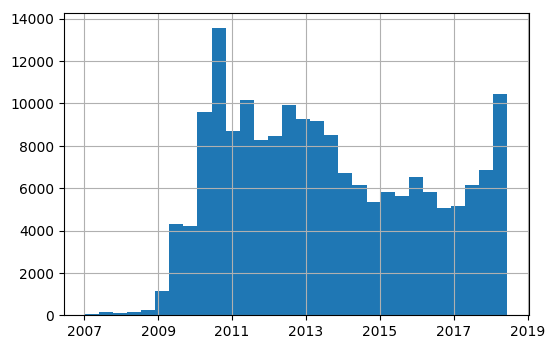

In [74]:
users_si.created_at.hist(bins=30)

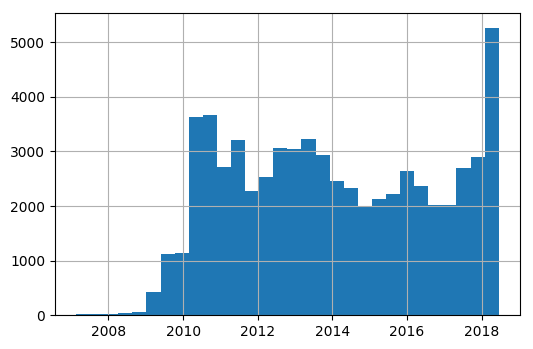

In [75]:
users_no.created_at.hist(bins=30)

## Cuentas verificadas

In [76]:
users_si.verified.value_counts()

False    181298
True     467   
Name: verified, dtype: int64

In [77]:
users_no.verified.value_counts()

False    64135
True     68   
Name: verified, dtype: int64

In [78]:
users_si[users_si.verified]

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified
2198,2010-06-16 11:45:01,El Trece - Radio Conexion Abierta,64723,383665,2528,True,156242969,es,Argentina,Luis Bremer,False,luisbremer,272602,None,True
2206,2010-08-01 19:29:48,Socióloga e investigadora. Activista del Nuevo Perú. Congresista de la República del Perú.,2490,249071,599,True,173544494,es,Peru,Marisa Glave,False,MarisaGlave,11125,None,True
2817,2011-02-25 12:05:58,Dirigente nacional del @PartidoObrero en el Frente de Izquierda,175,41003,506,True,257432060,es,Ciudad de Buenos Aires,Néstor Pitrola,False,nestorpitrola,31348,None,True
3012,2011-02-06 16:02:52,CONTRATACIONES e INFORMACION: Info@marianoberonmusic.com\nhttps://t.co/v2zpGtgV1G\n https://t.co/cyy6NwBUqV https://t.co/zifPcG4Lvc,31902,98604,293,True,248251555,es,Buenos Aires,Mariano Beron 🤪,False,Marianoberonok,7285,None,True
3581,2014-08-07 15:13:07,"Diputado del Parlasur. Ex Canciller de la Nación. Peronista. Sociólogo, Director del CIEP (UNSaM). Casado. Padre de tres hijxs.",1352,67952,558,False,2714771804,es,"Buenos Aires, Argentina",Jorge Taiana,False,JorgeTaiana,7228,None,True
3755,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,True,144712423,es,,🅰️NGELITO,False,AngeldebritoOk,262357,None,True
3811,2008-08-05 15:57:57,Productor Musical - DJ - Conductor de #MinutosContados - Radio De Plata,23377,318262,5455,True,15737712,es,,camilogarcia,False,camilogarcia,34843,None,True
3905,2010-05-18 13:11:02,Trabaja en https://t.co/5BLPuJ72et y en el El Brío Teatro. Mis opiniones por acá son a título personal,1233,1257,646,False,145237113,es,,Germán Leza,False,yeisonleza,3522,None,True
4702,2012-02-10 03:06:49,"Asimétrico. Actor, autor, director, editor y pichón de productor. Creador de #ChicosCatolicos y #LaMadreQLP | 🔜 @salvajesok | Agus&Pedro | Funebrero🇾🇪",11842,16073,8456,True,488114005,es,Argentina,Juan Paya™,False,juancitopaya,32987,None,True
4712,2010-12-27 23:20:15,Mamá de Margarita. Actriz argentina twitter oficial https://t.co/b7QxD5izkN,9009,947627,458,False,231222291,es,argentina,griselda siciliani,False,grisici,9161,None,True


In [79]:
users_no[users_no.verified]

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,name,protected,screen_name,statuses_count,time_zone,verified
1089,2008-12-03 04:06:54,Cuenta Oficial de ACI Prensa | Noticias y recursos sobre la Iglesia Católica en todo el mundo.,1462,262695,970,True,17828368,es,,ACI Prensa,False,aciprensa,74215,None,True
2971,2012-02-02 00:36:50,No respondo mensajes privados.,30886,289880,32188,True,480860644,es,,Viviana,False,vivicanosaok,19649,None,True
3755,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,True,144712423,es,,🅰️NGELITO,False,AngeldebritoOk,262357,None,True
11654,2015-11-16 00:55:37,"Presidente del Bloque PRO, Honorable Cámara de Diputados de la Nación",94,35876,142,True,4198001913,en,,Nicolás Massot,False,Nicolas_Massot,676,None,True
17446,2008-09-15 11:08:46,"Noticias desde Buenos Aires, Argentina. Periodismo puro en tiempo real.",276,738338,2207,True,16294264,es,Argentina,Perfil.com,False,perfilcom,170254,None,True
17583,2010-06-29 18:14:55,"Argentina, politóloga, madre de 3 hijos maravillosos y Secretaria de Infraestructura Urbana de la Nación.",3330,22908,846,True,160998065,es,Ciudad Autónoma de Buenos Aire,Marina Klemensiewicz,False,Klemensiewicz,5189,None,True
21500,2010-10-09 01:04:54,Cuenta Oficial de la Periodista de Espectaculos en @telefenoticias @buentelefe Corresponsal argentina de HOLATV para Miami y Latinoamerica. Canal 26/Late93.1,15712,257314,3308,True,200328797,es,argentina,Pilar Smith,False,Pilarsmith,44597,None,True
21832,2012-07-17 12:35:08,Todo Jujuy Diario digital. Noticias al instante las 24 hs.,562,15914,255,True,700978591,es,San Salvador de Jujuy,Todo Jujuy,False,diarioTodoJujuy,65031,None,True
24277,2009-09-03 21:11:47,"Coordinador de Análisis y Control de Gestión del @SFMyC.\n\nReflexiono sobre Liderazgo y desarrollo personal.\nCasado, 4 hijos. 💙💛💙\n https://t.co/gjF0xfAjRo",61292,94576,744,True,71360442,es,"Buenos Aires, Argentina",Ricardo R Benedetti,False,RicBenedetti,19438,None,True
25475,2011-01-13 03:26:06,"Bienvenidos a la cuenta oficial de Revista Noticias, el newsmagazine de lengua hispana más leído del mundo.",453,256854,1418,True,237562389,es,,Revista Noticias,False,noticiasrevista,17483,None,True
